In [28]:
import numpy as np
import matplotlib.pyplot as plt
import global_nav as global_nav
import global_display_functions as plt_glob
from IPython.display import Image
import matplotlib.image as mpimg
import math
import random

#### Setting Parameters to display

In [29]:
object_corners= [[(17.821782178217823, 80.86021505376344), (3.7128712871287126, 80.86021505376344), (3.7128712871287126, 90.3225806451613), (17.821782178217823, 90.3225806451613)], 
                 [(20.04950495049505, 20.43010752688172), (7.425742574257425, 20.43010752688172), (7.425742574257425, 28.602150537634408), (20.04950495049505, 28.602150537634408)], 
                 [(40.59405940594059, 47.31182795698925), (21.78217821782178, 47.31182795698925), (21.78217821782178, 61.72043010752688), (40.59405940594059, 61.72043010752688)], 
                 [(68.81188118811882, 9.67741935483871), (52.227722772277225, 9.67741935483871), (52.227722772277225, 26.451612903225808), (68.81188118811882, 26.451612903225808)], 
                 [(69.3069306930693, 73.97849462365592), (58.415841584158414, 73.97849462365592), (58.415841584158414, 85.3763440860215), (69.3069306930693, 85.3763440860215)]]

object_corners = global_nav.create_dictionnary(object_corners)
RandG = {'robot': (30, 85), 
         'goal': (34.65346534653465, 7.956989247311828)}

robot_size = 9

#### Growing obstacles

The function grow_obstacles is define for quadrilaterals since we had already decided to use only quadrilaterals as obstacles to ease the implementation of the shapes recognition. It takes the position of the oposite points and add or removes a value of robot_size in x and in y. The value of robot_siez is half of the robot dimension in theory but in reality we tuned this parameter to have the best result possible. Hence it will grow the obstacles to avoid collision.
To add or remove the value in x and y, I considered all the possibilities (case 1 to 4)

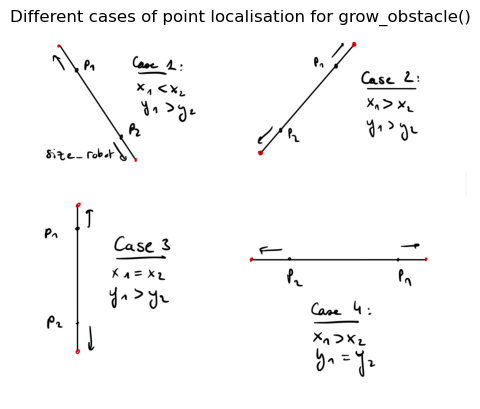

In [30]:
Image(filename='IMG_20CC1C4CB37F-1.jpeg')
img = mpimg.imread('IMG_20CC1C4CB37F-1.jpeg')
plt.imshow(img)
plt.axis('off')
plt.title('Different cases of point localisation for grow_obstacle()') 
plt.show()

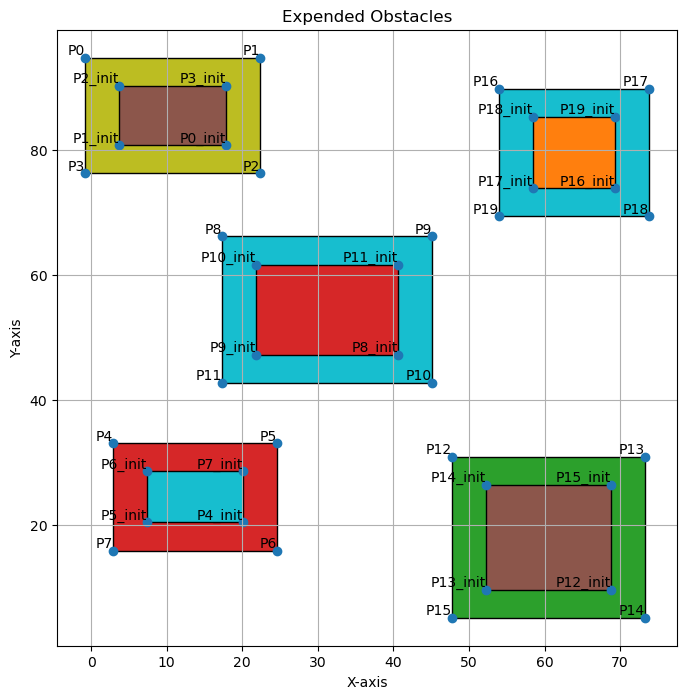

In [31]:
expended_corners = global_nav.grow_obstacles(object_corners, robot_size)
plt_glob.plot_expended_obstacles(object_corners, RandG, expended_corners)

### Finding the shortest path

We chose a map with printed obstacles. Thus these obstacles are seen only from top camera and not the robot sensors since these obstacles need to be avoided using a global planning. Moreover we decided to use a map whithout a grid. Hence the obvious choice of algorithm for global path was the Dijkstra algorithm. Dijkstra's algorithm is more flexible than many other algorithm and doesn't rely on a grid structure. It is an algorithm that can adapt to various shapes of obstacle. Moreover, Dijkstra algorithm is known to be very efficient to work with weighted graph. In our context, the weights are the distances between the points. The algorithm is optimal since it guarantees to always find a solution that will minimize the distance for any point in the map. Moreover, the algorithm can become computationally heavy if the map is too big or if there are too many connexions, but it is then robust in our case where the map is small with relatively few connections.

First to create the adjacency list. We need to be able to find if two points are connected. I first needed to create a function that says if two segment lines intersect. To do so, I studied the theory about point orientation[1] and created a function compute_orientation which returns the orientation of three given points. All points are defined as tuples corresponding to x and y coordinates. Then the intersect function finds if segments are connected, going through every case of orientation. 
The following plot is used to test the intersect function on 2 random segments: 

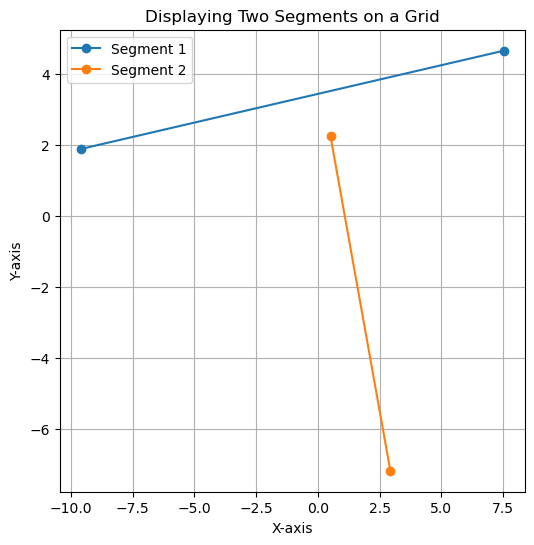

Are the segments crossing?  False


In [32]:
point1 = (random.uniform(-10, 10), random.uniform(-10, 10))
point2 = (random.uniform(-10, 10), random.uniform(-10, 10))
point3 = (random.uniform(-10, 10), random.uniform(-10, 10))
point4 = (random.uniform(-10, 10), random.uniform(-10, 10))
plt_glob.display_segments(point1, point2, point3, point4)
print("Are the segments crossing? ",global_nav.intersect (point1,point2,point3,point4))

Then using this. Two points are connected if we can draw a line between them without crossing any object segments. The function adjacency_list gows through every points and creates a new dictionnary saying which point is connected to which.

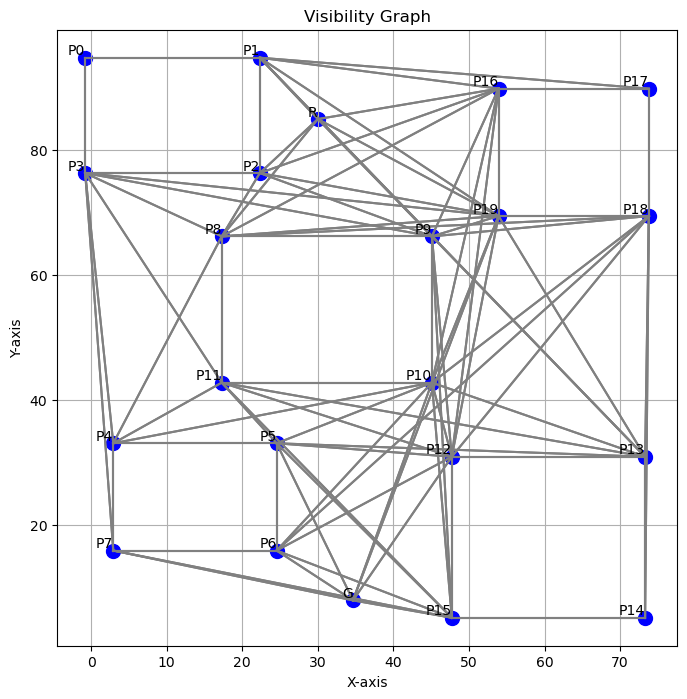

In [33]:
points_name2coord = global_nav.name2coord(expended_corners, RandG)
adjacent_list = global_nav.generate_adjacency_list(expended_corners, RandG, object_corners)
plt_glob.plot_visibility_graph(adjacent_list, points_name2coord)

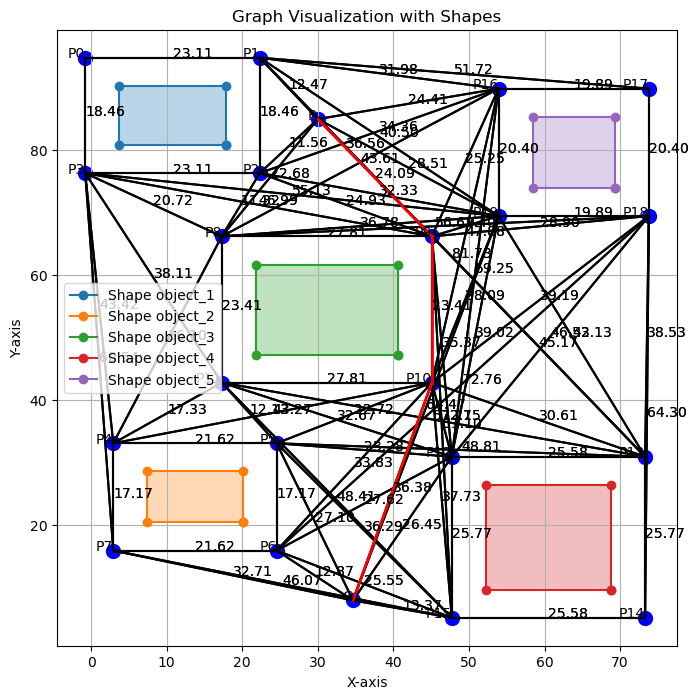

In [34]:
distances = global_nav.calculate_distances(adjacent_list, points_name2coord)

[short_path, adjacent_list, points_name2coord] = global_nav.shortest_path(RandG, object_corners, expended_corners)

path=[]
for name in short_path:
    path.append(points_name2coord[name])

short_path = short_path.reverse()
plt_glob.plot_graph_with_shapes(adjacent_list, points_name2coord, distances, path, object_corners)

### If the robot is inside an expended obstacle

When the robot avoid a local obstacle in front of it, it computes a new global path. During the local avoidance it could happend that the robot gets inside the grown obstacles zone. In this case, when the robot surch for a new global path, it could happend that the closest point is on the other side of an obstacle. Hence we have to consider this special case. If the robot gets in this zone, the adjacency list is updated so that only the points that don't cross the real obstacles are connected. Moreover, if somehow the robot got into an obstacle, the robot will then go to the extended obstacle corner the closest to the goal and find the shortest path from there.

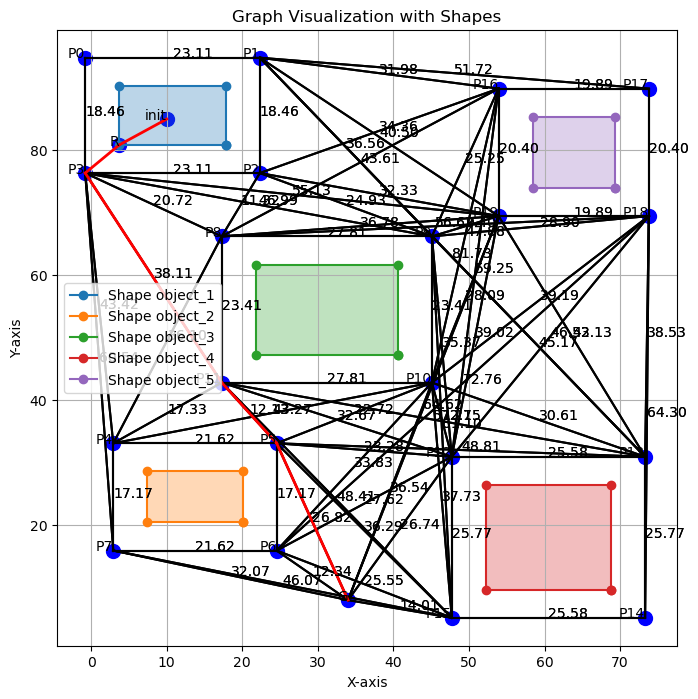

In [36]:
RandG = {'robot': (10, 85), 
         'goal': (34, 8)}

adjacent_list = global_nav.generate_adjacency_list(expended_corners, RandG, object_corners)
distances = global_nav.calculate_distances(adjacent_list, points_name2coord)
[short_path, adjacent_list, points_name2coord] = global_nav.shortest_path(RandG, object_corners, expended_corners)
path=[]
for name in short_path:
    path.append(points_name2coord[name])

short_path = short_path.reverse()
plt_glob.plot_graph_with_shapes(adjacent_list, points_name2coord, distances, path, object_corners)

[1] : 
* GeeksforGeeks, "How to check if two given line segments intersect?" [Video] https://www.youtube.com/watch?v=wCR48FqkI4w
* Geeksforgeeks, How to check if two given line segments intersect? (13 Jul, 2022) [webpage] https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/

[2] : 
* Francesco Mondada, 2023, slides of the course Basics of Mobile robotics
* Yvan Monka, "Utiliser l'algorithme de Dijkstra - PostBac" [video] https://youtu.be/rHylCtXtdNs?si=AHIMcMFKq95xQKFB
* Alexey Klochay, "Implementing Dijkstra’s Algorithm in Python", [webpage], Udacity, https://www.udacity.com/blog/2021/10/implementing-dijkstras-algorithm-in-python.html